In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
from plot_params import *

indir = Path('/tscc/nfs/home/s5xu/scratch/circSTAMP_pipe/1_basic_nextera/output')



In [2]:
!ls /tscc/nfs/home/s5xu/scratch/circSTAMP_pipe/1_basic_nextera/output/circle_summary

all_circle_annotation.csv  circ_type_counts.csv  FSJ_counts.csv
BSJ_counts.csv		   ciri_stats.csv	 junction_ratio.csv


In [3]:
mega_anno = pd.read_csv(indir / 'circle_summary/all_circle_annotation.csv', index_col = 0)
stats_df = pd.read_csv(indir / 'circle_summary/ciri_stats.csv', index_col = 0)
counts = pd.read_csv(indir / 'circle_summary/circ_type_counts.csv', index_col = 0)
bsj = pd.read_csv(indir / 'circle_summary/BSJ_counts.csv', index_col = 0)
fsj = pd.read_csv(indir / 'circle_summary/FSJ_counts.csv', index_col = 0)
junc = pd.read_csv(indir / 'circle_summary/junction_ratio.csv', index_col = 0)

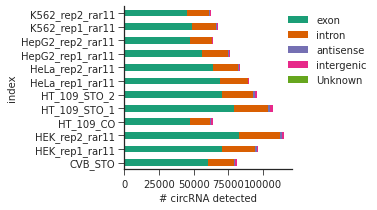

In [4]:
counts.sort_index().plot.barh(stacked = True, figsize = (3,3))
plt.xlabel('# circRNA detected')
plt.legend(bbox_to_anchor = (1.5, 1))
sns.despine()
plt.savefig(figdir / '5_n_circles.pdf')

# Overlap between circular RNAs in cell line

In [5]:
bsj.columns

Index(['HEK_rep1_rar11', 'HEK_rep2_rar11', 'HepG2_rep1_rar11',
       'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11',
       'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1',
       'HT_109_STO_2', 'CVB_STO'],
      dtype='object')

In [6]:
circname_reproducible = {}
for cell_line in ['K562', 'HepG2', 'HeLa', 'HEK']:
    circname_reproducible[cell_line]=set(bsj.loc[~bsj[f'{cell_line}_rep1_rar11'].isnull()].index).intersection(
                                    set(bsj.loc[~bsj[f'{cell_line}_rep2_rar11'].isnull()].index)
    )
# circname_reproducible['HEK293']=set(bsj.loc[~bsj[['HEK_rar11', 'circseq-bm-rar11-nxt']].isnull().any(axis = 1)].index)

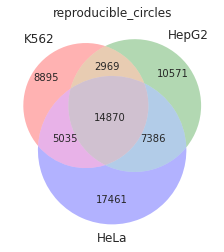

In [7]:
from matplotlib_venn import venn3
venn3([circname_reproducible[p] for p in ['K562', 'HepG2', 'HeLa']]
      , set_labels = ('K562', 'HepG2', 'HeLa'), 
      
      alpha = 0.3
     )
plt.title('reproducible_circles')
plt.savefig(figdir / '5_venn_3cellline.pdf')

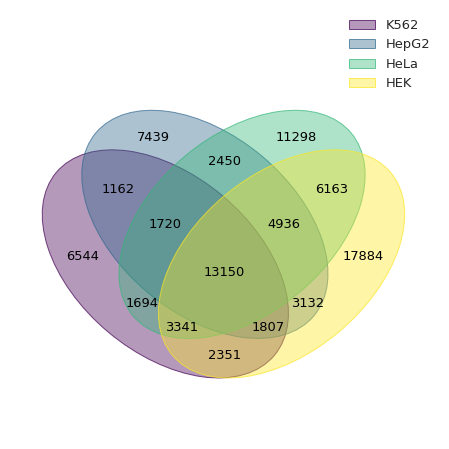

In [8]:
from venn import venn
venn(circname_reproducible)
plt.savefig(figdir / '5_venn_4cellline.pdf')

# Correlating CPM levels

In [9]:
cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6

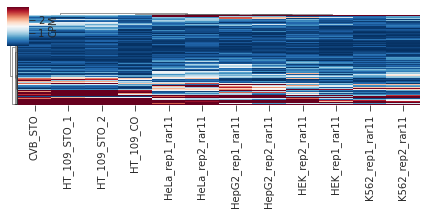

In [10]:
all_expressed = cpm.loc[cpm.isnull().sum(axis = 1)<1]
max_value = all_expressed.mean().median()
sns.clustermap(all_expressed, cmap = 'RdBu_r', vmax = max_value*2, 
              cbar_kws = {'label':'CPM'}, yticklabels = 0, dendrogram_ratio = 0.02,
              figsize = (6,3))
plt.savefig(figdir / '5_cell_line_CPM_clust.pdf')

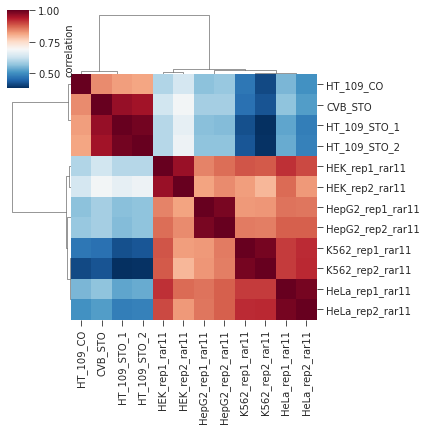

In [11]:
from scipy.spatial.distance import pdist, squareform
corr = pd.DataFrame(1-squareform(pdist(all_expressed.T, 'correlation')),
                    index = all_expressed.columns,
                    columns = all_expressed.columns)

sns.clustermap(corr, metric = 'correlation', cmap = 'RdBu_r', figsize = (6,6), cbar_kws = {'label': 'correlation'})
plt.savefig(figdir / '5_cell_line_CPM_corr.pdf')

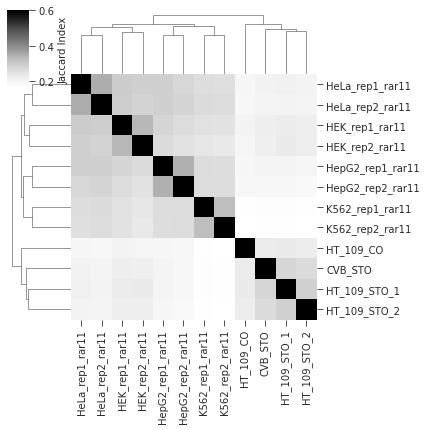

In [12]:
detected = (~cpm.isnull())

def compute_jaccard_index(identity_tbl):
    ''' use jaccard index to show how much binding site overlapped between RBPs'''
    d_condense = pdist(identity_tbl.T, 'jaccard')
    d = pd.DataFrame(1-squareform(d_condense), index = identity_tbl.columns, columns = identity_tbl.columns)
    return d_condense, d
jaccard_distance, jaccard_matrix = compute_jaccard_index(detected)
sns.clustermap(jaccard_matrix, metric = 'correlation', cmap = 'Greys', figsize = (6,6), cbar_kws = {'label': 'Jaccard Index'},
              vmax = 0.6)
plt.savefig(figdir / '5_cell_line_jaccard.pdf')

# Other analysis: what contributes to differentially expressed circles
- linear RNA expression: download from CCLE [here](https://www.ebi.ac.uk/gxa/experiments/E-MTAB-2770/Results)
- [link](https://www.ebi.ac.uk/gxa/experiments-content/E-MTAB-2770/resources/ExperimentDownloadSupplier.RnaSeqBaseline/fpkms.tsv)

- cell type specific casette exons?
- intron lengths

# The same gene express different circles?

In [13]:
coords = BedTool('/tscc/nfs/home/hsher/gencode_coords/gencode.v35.annotation.gff3')
from collections import defaultdict
exon_dict = defaultdict(lambda: list())
for c in coords:
    if c[2]=='exon':
        exon_dict[c.attrs['gene_name']].append([c.start, c.end])

In [14]:
def plot_bsj(gene):
    sub = cpm.loc[mega_anno.loc[mega_anno['gene_name']==gene].index].fillna(0)
    
    
    clines = sorted(list(sub.columns))
    
    max_cpm = sub.max().max()
    sub['start']=mega_anno['start']
    sub['end']=mega_anno['end']
    
    print(clines)
    f, ax = plt.subplots(1,int(len(clines)/2),  figsize = (int(3*len(clines)/2),3), sharex = True, sharey = True)
    for i,c in enumerate(clines): 
        if i%2==0:
            ax[i//2].scatter(sub['start'], sub['end'], (sub[c]/max_cpm)*10, label = c)
        else:
            ax[i//2].scatter(sub['end'],sub['start'],  (sub[c]/max_cpm)*10, label = c)
        ax[i//2].set_title(c.split('_')[0])
        ax[i//2].text(sub['start'].min(), sub['end'].max(), 'rep1')
        ax[i//2].text(sub['end'].max(), sub['start'].min(), 'rep2')
    sns.despine()
    
    # _ = [a.legend() for a in ax]
    _ = [a.set_ylabel('BSJ start/end') for a in ax]
    _ = [a.set_xlabel('BSJ start/end') for a in ax]
    
    min_ax = min([i[0] for i in exon_dict[gene]])
    max_ax = max([i[1] for i in exon_dict[gene]])
    # for a in ax:
    #     for exon in exon_dict[gene]:
    #         #print(exon, min_ax, max_ax)
    #         # if exon[0]>sub['start'].min():
    #         a.plot([min_ax]*2, exon, linewidth=7.0, color = 'lightgrey')
    #         a.plot(exon, [min_ax]*2,  linewidth=7.0, color = 'lightgrey')
    #         a.axhspan(exon[0], exon[1], xmin=min_ax, xmax=max_ax, color = 'lightgrey')
    #         a.axvspan(exon[0], exon[1], ymin=min_ax, ymax=max_ax, color = 'lightgrey')
            
    _ = [a.plot([min_ax, max_ax], [min_ax, max_ax], '--', color = 'black') for a in ax]
    
    plt.suptitle(gene)

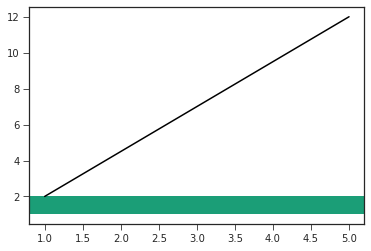

In [15]:

plt.plot([1,1,5], [2,2,12], color = 'black')
plt.axhspan(1,2)

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


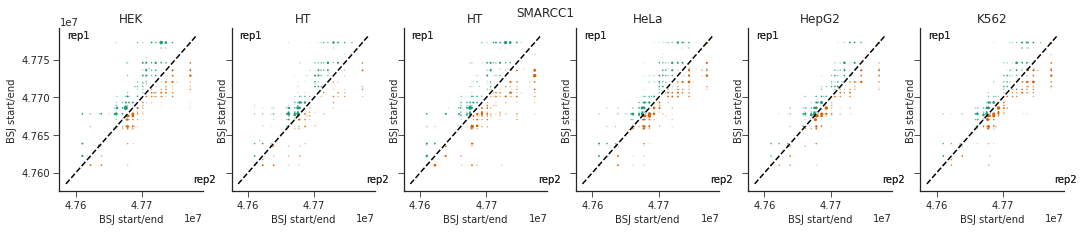

In [16]:
plot_bsj('SMARCC1')
plt.savefig(figdir / '5_BSJ_in_SMARCC1.pdf')

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


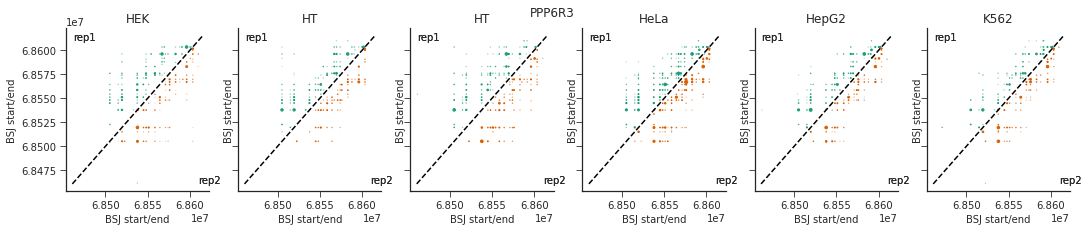

In [17]:
plot_bsj('PPP6R3')
plt.savefig(figdir / '5_BSJ_in_PPP6R3.pdf')

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


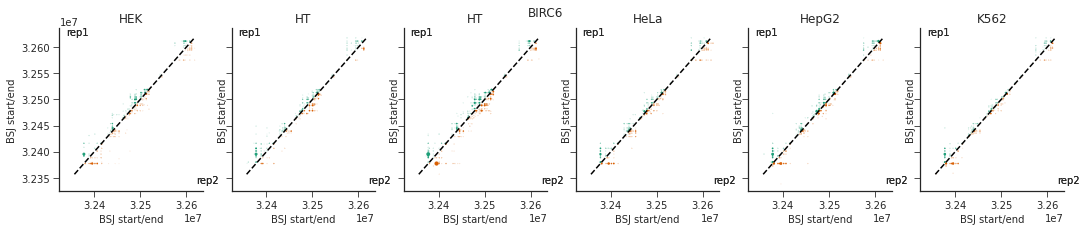

In [18]:
plot_bsj('BIRC6')
plt.savefig(figdir / '5_BSJ_in_BIRC6.pdf')

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


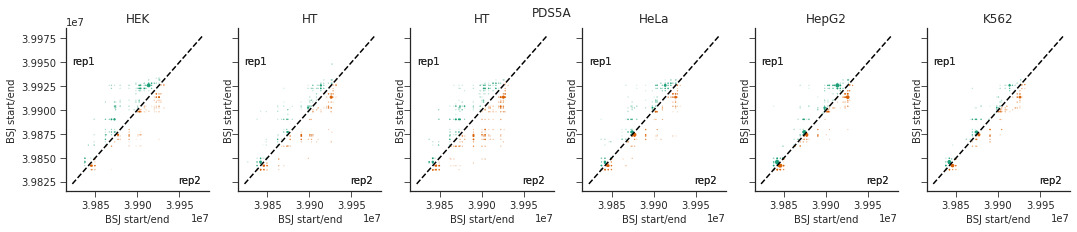

In [19]:
plot_bsj('PDS5A')
plt.savefig(figdir / '5_BSJ_in_PDS5A.pdf')

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


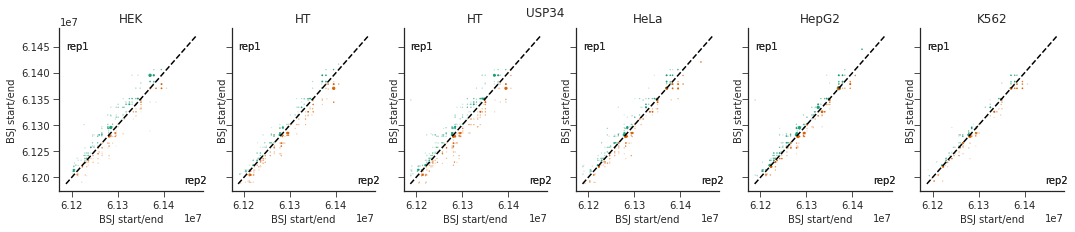

In [20]:
plot_bsj('USP34')
plt.savefig(figdir / '5_BSJ_in_USP34.pdf')

In [21]:
linear_rpkm = pd.read_csv('/tscc/projects/ps-yeolab5/hsher/ccle_datasets/CCLE_RNAseq_genes_rpkm_20180929.gct.gz',
                     skiprows = 2,
                     sep = '\t')

In [22]:
linear_rpkm.drop_duplicates(subset = ['Description'], inplace = True)

In [23]:
gene_length = {}
for c in coords:
    if c[2]=='gene':
        gene_length[c.attrs['gene_name']]=c.end-c.start

In [24]:
linear_rpkm['length']=linear_rpkm['Description'].map(gene_length)

In [25]:
cols = ['HEPG2_LIVER','K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE','HEKTE_KIDNEY','HELA_CERVIX']
linear_cpm = []
for c in cols:
    cpm_value=linear_rpkm.set_index('Description')[c]*linear_rpkm.set_index('Description')['length']
    cpm_value.name = c
    linear_cpm.append(cpm_value)
linear_cpm = pd.concat(linear_cpm, axis = 1)

In [26]:
cpm2 = cpm.copy()
cpm2['gene_name']=mega_anno['gene_name']
circ_cpm_sum_pergene = cpm2.groupby(by = 'gene_name').sum()
circ_cpm_sum_pergene = pd.concat([linear_cpm,circ_cpm_sum_pergene],axis = 1).dropna()

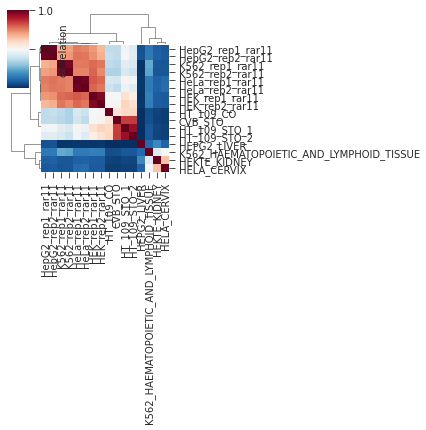

In [27]:
corr = pd.DataFrame(1-squareform(pdist(circ_cpm_sum_pergene.T, 'correlation')),
                    index = circ_cpm_sum_pergene.columns,
                    columns = circ_cpm_sum_pergene.columns)

sns.clustermap(corr, metric = 'correlation', cmap = 'RdBu_r', figsize = (6,6), cbar_kws = {'label': 'correlation'})
# plt.savefig(figdir / '5_cell_line_CPM_corr.pdf')



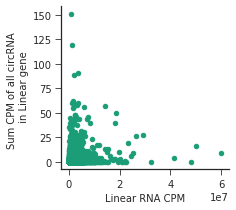

In [28]:


circ_cpm_sum_pergene.plot.scatter(x = 'K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
                                  y = 'K562_rep1_rar11',
                                 figsize = (3,3))
plt.ylabel('Sum CPM of all circRNA \n in Linear gene')
plt.xlabel('Linear RNA CPM')
sns.despine()

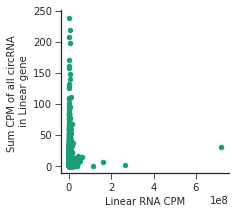

In [29]:
circ_cpm_sum_pergene.plot.scatter(x = 'HEPG2_LIVER',
                                  y = 'HepG2_rep1_rar11',
                                 figsize = (3,3))
plt.ylabel('Sum CPM of all circRNA \n in Linear gene')
plt.xlabel('Linear RNA CPM')
sns.despine()

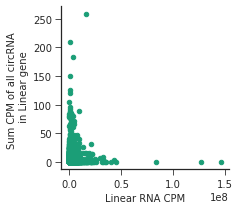

In [30]:
circ_cpm_sum_pergene.plot.scatter(x = 'HELA_CERVIX',
                                  y = 'HeLa_rep1_rar11',
                                 figsize = (3,3))
plt.ylabel('Sum CPM of all circRNA \n in Linear gene')
plt.xlabel('Linear RNA CPM')
sns.despine()

In [31]:
circ_cpm_sum_pergene.head()

,HEPG2_LIVER,K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HEKTE_KIDNEY,HELA_CERVIX,HEK_rep1_rar11,HEK_rep2_rar11,HepG2_rep1_rar11,HepG2_rep2_rar11,K562_rep1_rar11,K562_rep2_rar11,HeLa_rep1_rar11,HeLa_rep2_rar11,HT_109_CO,HT_109_STO_1,HT_109_STO_2,CVB_STO
SAMD11,1.960538e+03,1.342843e+04,2.409310e+04,5.205490e+05,0.956448,1.090790,0.000000,0.000000,0.000000,0.000000,0.008179,0.000000,0.055557,0.040100,0.000000,0.0
NOC2L,6.880589e+05,1.243841e+06,6.511721e+05,1.341580e+06,0.348560,0.863542,0.091757,0.161760,0.452725,0.742782,0.081787,0.387037,0.092595,0.133666,0.076504,0.0
ISG15,1.527808e+05,1.104019e+05,3.243030e+05,9.038326e+05,0.025096,0.012986,0.015293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
AGRN,1.870159e+06,7.062860e+05,3.698933e+06,2.072635e+06,0.022308,0.032464,0.000000,0.029411,0.000000,0.000000,0.032715,0.100630,0.000000,0.000000,0.015301,0.0
C1orf159,4.034566e+04,2.209358e+05,1.350246e+05,1.358042e+05,0.002788,0.016232,0.000000,0.000000,0.000000,0.058834,0.000000,0.007741,0.000000,0.000000,0.000000,0.0


# Differentially expressed circles

In [32]:
de_path = indir / 'circ_de_reps'

de_dict = {}
for f in de_path.glob('*gtf.tsv'):
    df = pd.read_csv(f, sep = ',', index_col = 0)
    
    df = df.merge(mega_anno, left_index = True, right_index = True)
    de_dict[f.name.replace('.gtf.tsv', '')] = df

In [33]:
de_stat = []
for comparison in de_dict:
    df = de_dict[comparison]
    up = df.loc[df['DE']==1, 'circ_type'].value_counts()
    up['type']='upregulated'
    up['name']=comparison
    down = df.loc[df['DE']==-1,'circ_type'].value_counts()
    down['type']='downregulated'
    down['name']=comparison
    
    de_stat.append(up)
    de_stat.append(down)
    
de_stat = pd.concat(de_stat, axis = 1).fillna(0)
    
    

MannwhitneyuResult(statistic=3260381.0, pvalue=0.0003714369476817327)
MannwhitneyuResult(statistic=640441.0, pvalue=2.087666395534693e-06)
MannwhitneyuResult(statistic=2965196.0, pvalue=1.2205354929386747e-43)
MannwhitneyuResult(statistic=925596.5, pvalue=3.6130325981778907e-51)
MannwhitneyuResult(statistic=5431422.0, pvalue=6.647360460937691e-45)
MannwhitneyuResult(statistic=585284.0, pvalue=1.751398213033558e-24)


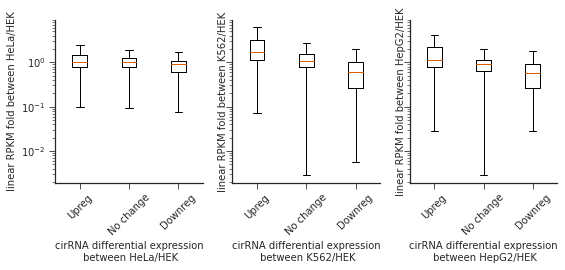

In [34]:
from scipy.stats import mannwhitneyu
f, axes = plt.subplots(1,3, figsize = (9,3), sharey = True)
for ax,comparison in zip(axes,de_dict):
    df = de_dict[comparison]
    cond1, cond2 = comparison.split('_vs_')
    cond1_col = [c for c in cols if cond1.upper() in c][0]
    cond2_col = [c for c in cols if cond2.upper() in c][0]
    
    up = df.loc[df['DE']==1, 'gene_name'].dropna().unique()
    nc = df.loc[df['DE']==0,'gene_name'].dropna().unique()
    down = df.loc[df['DE']==-1,'gene_name'].dropna().unique()
    
    linear_fc_up = (linear_rpkm.loc[linear_rpkm['Description'].isin(up), cond1_col]+1)/(linear_rpkm.loc[linear_rpkm['Description'].isin(up), cond2_col]+1)
    linear_fc_nc = (linear_rpkm.loc[linear_rpkm['Description'].isin(nc), cond1_col]+1)/(linear_rpkm.loc[linear_rpkm['Description'].isin(nc), cond2_col]+1)
    linear_fc_down = (linear_rpkm.loc[linear_rpkm['Description'].isin(down), cond1_col]+1)/(linear_rpkm.loc[linear_rpkm['Description'].isin(down), cond2_col]+1)
    
    ax.boxplot([linear_fc_up, linear_fc_nc, linear_fc_down], showfliers = False)
    ax.set_yscale('log')
    ax.set_xticklabels(['Upreg', 'No change','Downreg'], rotation = 45)
    ax.set_ylabel(f'linear RPKM fold between {cond1}/{cond2}')
    ax.set_xlabel(f'cirRNA differential expression\n between {cond1}/{cond2}')
    

    print(mannwhitneyu(linear_fc_up, linear_fc_nc))
    print(mannwhitneyu(linear_fc_down, linear_fc_nc))
sns.despine()
plt.savefig(figdir / '5_cell_line_corr_linear.pdf')

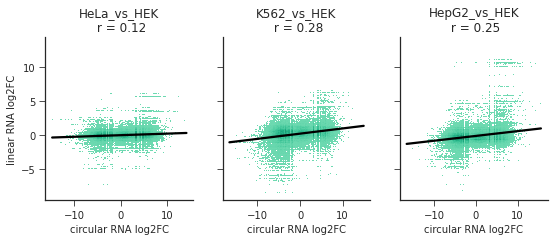

In [35]:
# fold change correlation plots
import numpy as np
from scipy.stats import pearsonr
f, axes = plt.subplots(1,3, figsize = (9,3), sharey = True)
for ax,comparison in zip(axes,de_dict):
    df = de_dict[comparison]
    cond1, cond2 = comparison.split('_vs_')
    cond1_col = [c for c in cols if cond1.upper() in c][0]
    cond2_col = [c for c in cols if cond2.upper() in c][0]

    linear_fc = np.log2((linear_rpkm.set_index('Description')[cond1_col]+1
                        )/(linear_rpkm.set_index('Description')[cond2_col]+1))
    df['log_linear_fc']=df['gene_name'].map(linear_fc)

    sns.histplot(data = df, x = 'logFC', y = 'log_linear_fc', ax = ax)
    sns.regplot(data = df, x = 'logFC', y = 'log_linear_fc', scatter = False, ax = ax, color = 'black')
    ax.set_xlabel('circular RNA log2FC')
    ax.set_ylabel('linear RNA log2FC')
    

    nona = df[['log_linear_fc', 'logFC']].dropna()
    r, p = pearsonr(nona['log_linear_fc'], nona['logFC'])
    ax.set_title(f'{comparison}\n r = {r:.2f}')
sns.despine()
plt.savefig(figdir / '5_cell_line_logFC_corr.pdf')

In [36]:
diff_set = {}
for comparison in de_dict:
    df = de_dict[comparison]
    diff = set(df.loc[(df['DE']==1)|(df['DE']==-1), 'gene_name'].dropna().unique())
    
    diff_set[comparison]=diff

In [37]:
very_different = diff_set['HepG2_vs_HEK'].intersection(diff_set['K562_vs_HEK']).intersection(diff_set['HeLa_vs_HEK'])

In [38]:
linear_rpkm.loc[linear_rpkm['Description'].isin(very_different)
               ].set_index('Description')[cols].median(axis = 1).sort_values().iloc[-50:]

Description
FBXO4       5.685850
CPQ         5.773885
COG5        5.792555
PLD1        5.847095
ZBTB38      5.981550
PTEN        6.136350
DUSP16      6.519855
DYRK1A      6.580680
ELF2        7.286695
ZDHHC17     7.361530
ANAPC1      7.418995
SMOC1       7.925307
KIF13A      8.139875
EXOC5       9.012920
PDE8A       9.076400
PAWR        9.340245
DIP2B       9.813700
ANKIB1      9.868280
EP300      10.134860
SUSD1      10.954700
LARP4      11.710350
EDC3       11.976100
USP34      12.234400
TRIM37     12.247900
TBL1XR1    12.606400
MLLT6      13.665400
KIF18B     14.002800
ROCK2      15.049385
ASH2L      15.148400
ZMYND8     15.777730
TAX1BP1    15.816150
ATP6V1D    15.880200
USP33      17.274650
MRPL42     17.532600
DSP        18.144400
SPG21      18.287300
TFPI       20.101450
HUWE1      20.290300
PSMD5      20.319530
PPP6R3     20.356700
NEAT1      20.830550
MLH1       21.317000
PTPN12     22.253300
REEP5      25.631700
VMP1       31.187800
YME1L1     34.875400
MTCH2      41.144350
P

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


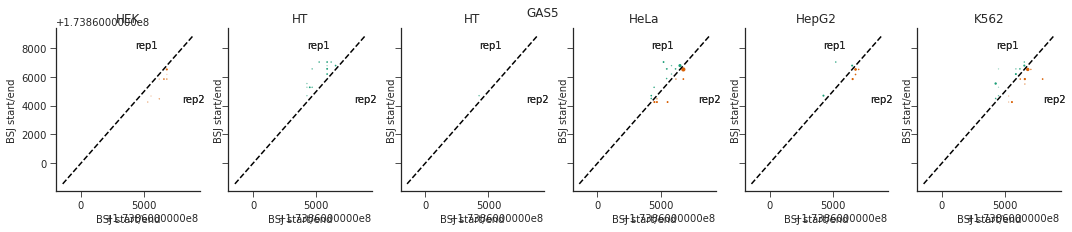

In [39]:
plot_bsj('GAS5')

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


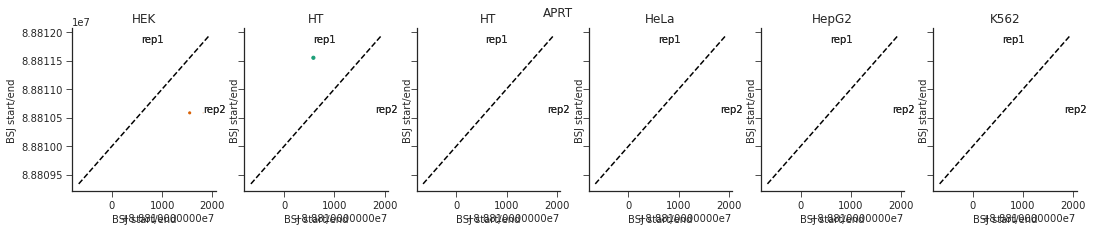

In [40]:
plot_bsj('APRT')

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


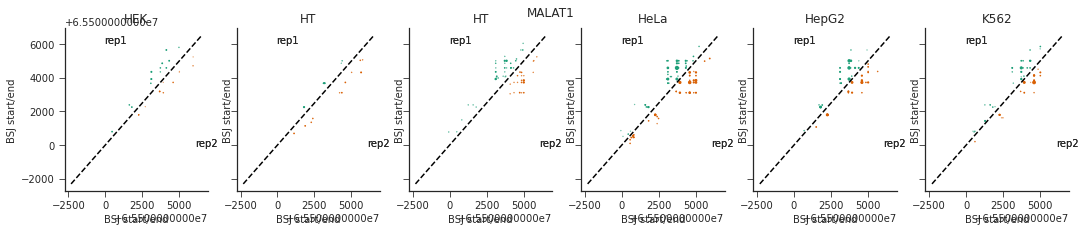

In [41]:
plot_bsj('MALAT1')

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


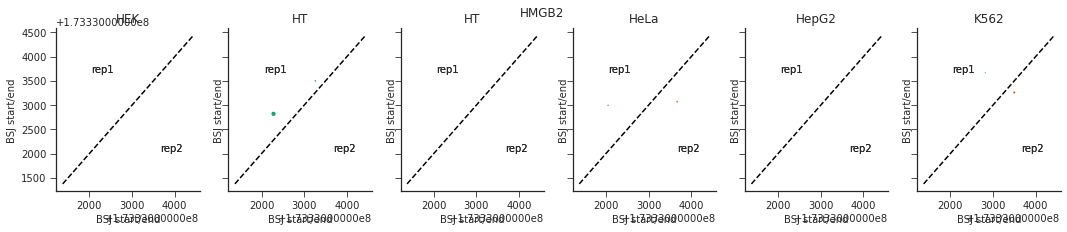

In [42]:
plot_bsj('HMGB2')

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


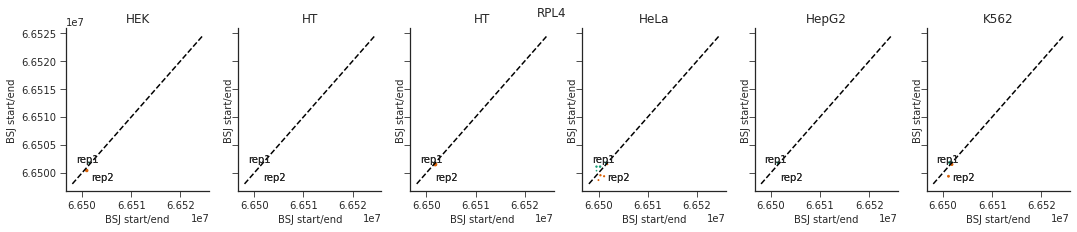

In [43]:
plot_bsj('RPL4')

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


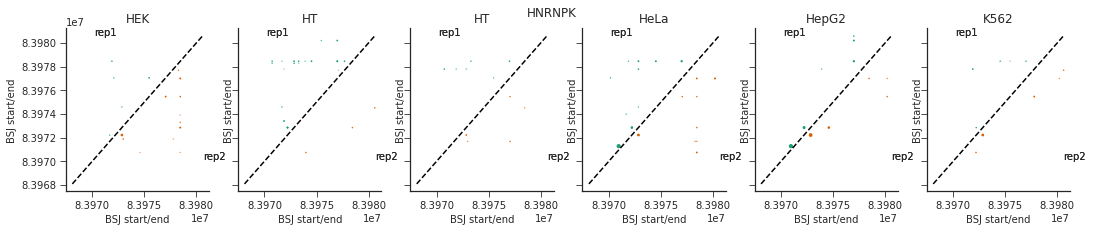

In [44]:
plot_bsj('HNRNPK')

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


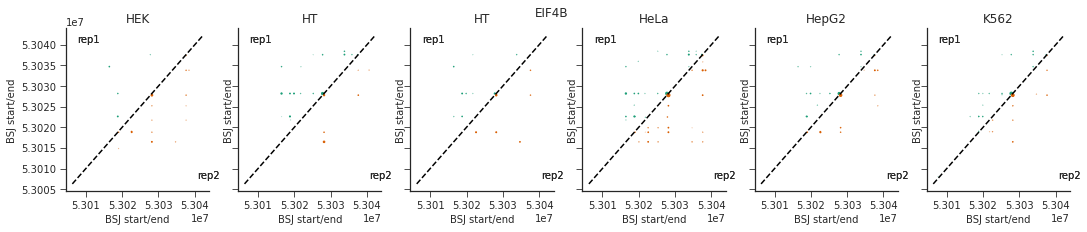

In [45]:
plot_bsj('EIF4B')

['CVB_STO', 'HEK_rep1_rar11', 'HEK_rep2_rar11', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2', 'HeLa_rep1_rar11', 'HeLa_rep2_rar11', 'HepG2_rep1_rar11', 'HepG2_rep2_rar11', 'K562_rep1_rar11', 'K562_rep2_rar11']


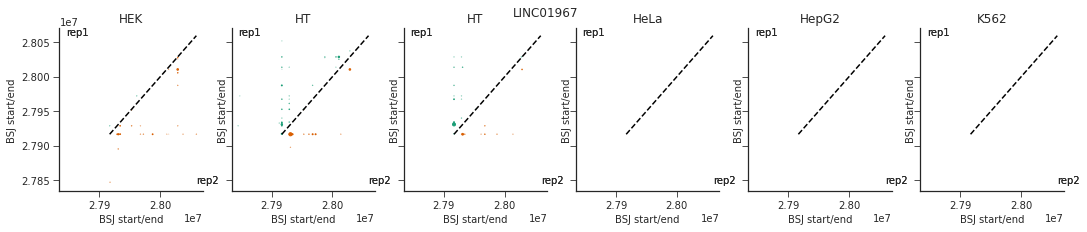

In [46]:
plot_bsj('LINC01967')

In [47]:
mega = [de_dict[name][['logFC', 'FDR']].rename({
    'logFC':f'logFC_{name}',
    'FDR':f'FDR_{name}',
    
    }, axis = 1)
    for name in de_dict]

In [48]:
mega = pd.concat(mega,axis = 1)


In [49]:
mega.merge(mega_anno, left_index = True, right_index = True)

,logFC_HeLa_vs_HEK,FDR_HeLa_vs_HEK,logFC_K562_vs_HEK,FDR_K562_vs_HEK,logFC_HepG2_vs_HEK,FDR_HepG2_vs_HEK,seqname,start,end,strand,circ_type,gene_id,gene_name,gene_type
chr8:127140744|127149672,14.601120,1.832111e-14,NaN,NaN,12.529565,1.023887e-08,chr8,127140744.0,127149672.0,-,exon,ENSG00000254166.3,CASC19,lncRNA
chr6:136151160|136155758,14.204485,1.511442e-13,NaN,NaN,NaN,NaN,chr6,136151160.0,136155758.0,+,exon,ENSG00000171408.14,PDE7B,protein_coding
chr7:128641203|128648982,14.163939,1.511442e-13,13.472750,1.012733e-10,14.373270,1.859102e-12,chr7,128641203.0,128648982.0,+,intergenic,NaN,NaN,NaN
chr15:94440176|94458246,13.969137,4.417752e-13,NaN,NaN,12.871242,2.964610e-09,chr15,94440176.0,94458246.0,+,exon,ENSG00000140563.15,MCTP2,protein_coding
chr9:120831331|120833456,13.843029,8.341440e-13,13.438158,1.183551e-10,11.724513,9.506595e-07,chr9,120831331.0,120833456.0,-,exon,ENSG00000095261.14,PSMD5,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:12907537|12917542,NaN,NaN,NaN,NaN,3.368082,5.350078e-01,chrY,12907537.0,12917542.0,+,exon,ENSG00000067048.17,DDX3Y,protein_coding
chrY:13393859|13414793,NaN,NaN,NaN,NaN,3.368082,5.350078e-01,chrY,13393859.0,13414793.0,-,exon,ENSG00000183878.15,UTY,protein_coding
chrY:14622009|14723269,NaN,NaN,NaN,NaN,3.368082,5.350078e-01,chrY,14622009.0,14723269.0,+,exon,"ENSG00000165246.14,ENSG00000226555.1","NLGN4Y,AGKP1","protein_coding,processed_pseudogene"
chrY:14699393|14701132,NaN,NaN,NaN,NaN,3.368082,5.350078e-01,chrY,14699393.0,14701132.0,+,intron,ENSG00000165246.14,NLGN4Y,protein_coding


In [50]:
# mega.to_csv(figdir/'cell_type_de_circ.csv')